In [1]:
# Install required package
import sys
!{sys.executable} -m pip install --user --upgrade steam-nb-api

import os
import csv
from pathlib import Path
import numpy as np
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.lines as lines

from steam_nb_api.ledet.ParametersLEDET import ParametersLEDET
from steam_nb_api.utils import misc
from steam_nb_api.roxie_parser import MagneticCoil
from steam_nb_api.utils.SelfMutualInductanceCalculation import SelfMutualInductanceCalculation

from steam_nb_api.roxie_parser import CableDatabase
from steam_nb_api.roxie_parser import ConductorPosition
from steam_nb_api.roxie_parser.geometricFunctions import close_pairs_ckdtree, close_pairs_pdist

Requirement already up-to-date: steam-nb-api in /eos/home-m/mjanitsc/.local/lib/python3.7/site-packages (0.3.6)


# Global variables

In [2]:
nameMagnet = 'MCBXV'

# Define style for plots
selectedFont = {'fontname':'DejaVu Sans', 'size':14}

# If this variable is set to True, many comments will be displayed
verbose = False

# Load default LEDET variable descriptions
paramLEDET_notebook = ParametersLEDET()

# Generate magnet geometry parsing .data and .cadata files

In [3]:
# Select ROXIE .cadata file with conductor data
currentDirectory = Path(os.path.split(os.getcwd())[0])
fileNameCadata = os.path.join(currentDirectory,'resources','roxie.cadata')
fileNameData = nameMagnet + '_All_WithIron_WithSelfField.data'
    
# Define the magnetic coil
definedMagneticCoil = MagneticCoil.MagneticCoil()
xPos, yPos, iPos, xBarePos, yBarePos, xS, yS, iS = definedMagneticCoil.generateCoilGeometry(fileNameData, fileNameCadata, verbose=verbose)

# Array, that defines each group--> [No. of Layers, Ribbons per Group]
GeoArr = [[8,12],[8,19],[8,9],[8,5]]*4
#Define neighboring conductors, between whom wedges should be defined
flag_AutomaticWedgeNeighbors = 1
WedgeNeighbors = []
GroupsPerQuadrant = 4
if flag_AutomaticWedgeNeighbors:
    Quadrants = len(GeoArr)/GroupsPerQuadrant
    CondCounter = 1
    GroupCounter = 1
    for i in range(len(GeoArr)):
        if GroupCounter == 1:
            if (i/GroupsPerQuadrant)%2 == 0 and i <(Quadrants/2)*GroupsPerQuadrant:
                backConnec = CondCounter
                for j in range(int(GroupsPerQuadrant  * (Quadrants/2 +1))): backConnec = backConnec + GeoArr[j][1]
                WedgeNeighbors.append([CondCounter,backConnec])
            if (i/GroupsPerQuadrant)%2 == 0 and i>=(Quadrants/2)*GroupsPerQuadrant:
                backConnec = CondCounter
                for j in range(int(GroupsPerQuadrant  * (Quadrants/2 -1 ))):backConnec = backConnec - GeoArr[i-j][1]
                WedgeNeighbors.append([CondCounter,backConnec])
            if (i/GroupsPerQuadrant)%2 != 0 and i>=(Quadrants/2)*GroupsPerQuadrant:
                backConnec1 = CondCounter-1
                for j in range(0,GroupsPerQuadrant): backConnec1 = backConnec1 + GeoArr[i+j][1]
                backConnec2 = backConnec1
                for j in range(int(GroupsPerQuadrant  * (Quadrants/2))): backConnec2 = backConnec2 - GeoArr[i-j][1]
                WedgeNeighbors.append([backConnec1,backConnec2])
            WedgeNeighbors.append([GeoArr[i][1]+CondCounter-1,GeoArr[i][1]+CondCounter])
        elif GroupCounter == GroupsPerQuadrant and ((i+1)/GroupsPerQuadrant)%2 != 0 and i <=(Quadrants/2)*GroupsPerQuadrant:
            forConnec = CondCounter
            for j in range(int(GroupsPerQuadrant  * (Quadrants/2))):
                forConnec = forConnec + GeoArr[j][1]
            WedgeNeighbors.append([GeoArr[i][1]+CondCounter-1,forConnec+GeoArr[i][1]-1])
            GroupCounter = 0
        elif GroupCounter == GroupsPerQuadrant: GroupCounter = 0
        else: WedgeNeighbors.append([GeoArr[i][1]+CondCounter-1,GeoArr[i][1]+CondCounter])
            
        CondCounter = CondCounter + GeoArr[i][1]
        GroupCounter = GroupCounter +1
        
# Manually delete non-exisiting Wedges

#Extract Edges
xPosWedge = []
yPosWedge = []
for i in range(len(WedgeNeighbors)):
    #Left-Inner-Point
    if xPos[WedgeNeighbors[i][0]-1][0] != xPos[WedgeNeighbors[i][1]-1][0]:
        Idx0 = np.argmin([max(xPos[WedgeNeighbors[i][0]-1][0],xPos[WedgeNeighbors[i][0]-1][1]),
                          max(xPos[WedgeNeighbors[i][1]-1][0],xPos[WedgeNeighbors[i][1]-1][1])])
        Idx0_0 = np.argmax([xPos[WedgeNeighbors[i][Idx0]-1][0],xPos[WedgeNeighbors[i][Idx0]-1][1]])
    else:
        Idx0 = np.argmin([max(yPos[WedgeNeighbors[i][0]-1][0],yPos[WedgeNeighbors[i][0]-1][1]),
                          max(yPos[WedgeNeighbors[i][1]-1][0],yPos[WedgeNeighbors[i][1]-1][1])])
        Idx0_0 = np.argmax([yPos[WedgeNeighbors[i][Idx0]-1][0],yPos[WedgeNeighbors[i][Idx0]-1][1]])
    Pos0 = xPos[WedgeNeighbors[i][Idx0]-1][Idx0_0]
    yPos0 = yPos[WedgeNeighbors[i][Idx0]-1][Idx0_0]
    if Idx0_0 == 0: 
        Pos3 = xPos[WedgeNeighbors[i][Idx0]-1][3]
        yPos3 = yPos[WedgeNeighbors[i][Idx0]-1][3]
    else: 
        Pos3 = xPos[WedgeNeighbors[i][Idx0]-1][2]
        yPos3 = yPos[WedgeNeighbors[i][Idx0]-1][2]
    #Right-Inner-Point
    Idx1 = 1 - Idx0
    if xPos[WedgeNeighbors[i][0]-1][0] != xPos[WedgeNeighbors[i][1]-1][0]:
        Idx1_0 = np.argmin([xPos[WedgeNeighbors[i][Idx1]-1][0],xPos[WedgeNeighbors[i][Idx1]-1][1]])
    else:
        Idx1_0 = np.argmin([yPos[WedgeNeighbors[i][Idx1]-1][0],yPos[WedgeNeighbors[i][Idx1]-1][1]])
    Pos1 = xPos[WedgeNeighbors[i][Idx1]-1][Idx1_0]   
    if Idx1_0 == 0: 
        Pos2 = xPos[WedgeNeighbors[i][Idx1]-1][3]
        yPos2 = yPos[WedgeNeighbors[i][Idx1]-1][3]
    else: 
        Pos2 = xPos[WedgeNeighbors[i][Idx1]-1][2]
        yPos2 = yPos[WedgeNeighbors[i][Idx1]-1][2]
    yPos1 = yPos[WedgeNeighbors[i][Idx1]-1][Idx1_0]
        
    xPosWedge.append([Pos0, Pos1, Pos2, Pos3])
    yPosWedge.append([yPos0, yPos1, yPos2, yPos3])
    xBarePosWedge = [0,0,0,0]
    yBarePosWedge = [0,0,0,0]
    iPosWedge = 0
    xBarePos.append(xBarePosWedge)
    yBarePos.append(yBarePosWedge)
    iPos.append(iPosWedge)

xPos = xPos + xPosWedge
yPos = yPos + yPosWedge

# Plot conductors and their numbers
f = plt.figure(2, figsize=(10, 10))
ax = f.add_subplot(111)

# Plot edges
for c, (cXPos, cYPos) in enumerate(zip(xPos, yPos)):
    pt1, pt2, pt3, pt4 = (cXPos[0], cYPos[0]), (cXPos[1], cYPos[1]), (cXPos[2], cYPos[2]), (cXPos[3], cYPos[3])
    if iPos[c] > 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='r', edgecolor='k', alpha=.25)
    elif iPos[c] < 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='b', edgecolor='k', alpha=.25)
    elif iPos[c] == 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='grey', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)
    # Plot conductor numbers
    x_ave_cond, y_ave_cond = sum(cXPos) / len(cXPos), sum(cYPos) / len(cYPos)
    plt.text(x_ave_cond, y_ave_cond, '{}'.format(c + 1))

# Plot edges of bare conductors
for c, (cXBarePos, cYBarePos) in enumerate(zip(xBarePos, yBarePos)):
    pt1, pt2, pt3, pt4 = (cXBarePos[0], cYBarePos[0]), (cXBarePos[1], cYBarePos[1]), (cXBarePos[2], cYBarePos[2]), (
    cXBarePos[3], cYBarePos[3])
    if iPos[c] > 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=False, facecolor='r', edgecolor='k', alpha=.25)
    elif iPos[c] < 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=False, facecolor='b', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)

plt.xlabel('x [m]', **selectedFont)
plt.ylabel('y [m]', **selectedFont)
plt.title('Conductors and their numbers', **selectedFont)
plt.set_cmap('jet')
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
plt.grid()

File with cable database: /eos/home-m/mjanitsc/SWAN_projects/steam-notebooks/steam-ledet-input/resources/roxie.cadata
Block definition parameters have 8 rows
Group definition parameters have 1 row
Transformation definition parameters have 1 row
typexy = 2: One coil.



<IPython.core.display.Javascript object>

In [4]:
fileName = nameMagnet + '_ROXIE_All_WithIron_WithSelfField.map2d'
Wedges = True

if Wedges:
    # Read file
    file = open(fileName, "r")
    fileContent = file.read()

    # Separate rows
    Number_Wedges = len(WedgeNeighbors)
    fileContentByRow = fileContent.split("\n")
    NewMap2d = np.array([[ None for x in range(10)] 
                 for y in range(2,len(fileContentByRow)-1+Number_Wedges)])
    
    # Construct Wedge Fieldmaps
    wedge_length = np.sqrt((xPos[0][0]-xPos[0][3])**2+(yPos[0][0]-yPos[0][3])**2)

    x_ave_wedge = (np.sum(xPosWedge, axis=1)/4 ) *1000 #x-Offset of 0.097
    y_ave_wedge = (np.sum(yPosWedge, axis=1)/4 ) *1000 #y-Offset of -0.097
    
    #Artificially adjust pole wedges because of size -- Note: Not generic, do not copy for other than MCBX_HV
    x_ave_wedge[4] = -51.8
    x_ave_wedge[12] = 51.8
    
    #Create Wedges
    TotalCond = len(fileContentByRow)-3
    TotalGroups = 0
    for i in range(len(GeoArr)):
        TotalGroups = TotalGroups + GeoArr[i][0]
    
    # Create wedges
    wedge_map2d = []
    wedge_outplanes = []
    wedge_areas = []
    wedge_midplanes = []
    try:
        for i in range(Number_Wedges):
            midplane = np.sqrt(abs(xPosWedge[i][0] - xPosWedge[i][1])**2 + abs(yPosWedge[i][0] - yPosWedge[i][1])**2)
            wedge_midplanes.append(midplane)
            outplane = np.sqrt(abs(xPosWedge[i][2] - xPosWedge[i][3])**2 + abs(yPosWedge[i][2] - yPosWedge[i][3])**2)
            wedge_outplanes.append(outplane)
            #Trapezoidal area
            alpha = np.arccos((outplane-midplane)/(2*wedge_length))
            h = wedge_length*np.sin(alpha)
            wedge_area= (midplane+outplane)/2 * h
            wedge_areas.append(wedge_area)

            if i<Number_Wedges/2:
                new_wedge = [int(TotalGroups/2 + i+1), int(TotalCond/2 +i+1), int(TotalCond/2 +i+1), \
                            x_ave_wedge[i], y_ave_wedge[i], 0,0, wedge_area* 1000000, 0, 0]
                wedge_map2d.append(new_wedge)
            if i>=Number_Wedges/2:
                new_wedge = [int(TotalGroups+ i+1), int(TotalCond+i+1), int(TotalCond+i+1), \
                            x_ave_wedge[i], y_ave_wedge[i], 0,0, wedge_area* 1000000, 0, 0]
                wedge_map2d.append(new_wedge)
        Idx_FirstWedgeBlock = int(TotalCond/2)
        NumberHalf_Wedges = int(Number_Wedges/2)
        Idx_SecondWedgeBlock = int(TotalCond+Number_Wedges/2)
    except:
        print("Number of Wedges is not even")

    # Reorder Entries according to GeoArr and Type Ribbon Cable
    CondCounter = 0
    WedgeOffset = 0
    for k in range(len(GeoArr)):
        if k==len(GeoArr)/2:
            WedgeOffset=int(Number_Wedges/2)
        
        for j in range(GeoArr[k][0]):
            for i in range(GeoArr[k][1]):
                fc = fileContentByRow[j+i*GeoArr[k][0]+2+CondCounter]
                NewMap2d[i+j*GeoArr[k][1]+CondCounter+WedgeOffset,:]=fc.split()
                NewMap2d[i+j*GeoArr[k][1]+CondCounter+WedgeOffset,0]=j+k*GeoArr[k][0]+1+WedgeOffset
                NewMap2d[i+j*GeoArr[k][1]+CondCounter+WedgeOffset,1]=int(NewMap2d[i+j*GeoArr[k][1]+CondCounter+WedgeOffset,1])\
                                                                        +WedgeOffset
                NewMap2d[i+j*GeoArr[k][1]+CondCounter+WedgeOffset,2]=int(NewMap2d[i+j*GeoArr[k][1]+CondCounter+WedgeOffset,2])\
                                                                        +WedgeOffset
        CondCounter = CondCounter + GeoArr[k][0]*GeoArr[k][1]
        
    NewMap2d[Idx_FirstWedgeBlock:Idx_FirstWedgeBlock+NumberHalf_Wedges]=wedge_map2d[0:NumberHalf_Wedges]
    NewMap2d[Idx_SecondWedgeBlock:]=wedge_map2d[NumberHalf_Wedges:]

    # Write new .map2d File
    mat = np.matrix(NewMap2d)
    head = np.array(fileContentByRow[0].split()).transpose()
    head_merge = np.array([ None for x in range(10)])
    for i in range(head_merge.shape[0]-1):
        head_merge[i]=head[i]
    head_merge[9] = head[9]+" "+head[10]
    mat = mat.astype(float)
    CondNumbers  = np.array([np.linspace(1,len(fileContentByRow)-3+Number_Wedges,
                                         len(fileContentByRow)-3+Number_Wedges).astype(int)]).transpose()
    mat[:,2] = CondNumbers
    mat[:,1] = mat[:,2]
    with open(nameMagnet + '_CopperWedges_All_WithIron_WithSelfField.map2d','wb') as f:
        np.savetxt(f,np.array([head_merge]), fmt="%s")
        np.savetxt(f,[""],fmt="%s")
        for row in mat:
            np.savetxt(f,row, fmt=["%i","%i","%i","%.4f","%.4f","%.4f","%.4f","%.4f","%.4f","%.4f"])
            
    ## Repeat for NoIron file - for consistency - No wedges included
    fileName = nameMagnet + '_ROXIE_All_NoIron_NoSelfField.map2d'
    # Read file
    file = open(fileName, "r")
    fileContent = file.read()

    # Separate rows
    fileContentByRow = fileContent.split("\n")
    NewMap2d = np.array([[ None for x in range(10)] 
                 for y in range(2,len(fileContentByRow)-1)])
    # Reorder Entries according to GeoArr and Type Ribbon Cable
    CondCounter = 0
    for k in range(len(GeoArr)):
        for j in range(GeoArr[k][0]):
            for i in range(GeoArr[k][1]):
                fc = fileContentByRow[j+i*GeoArr[k][0]+2+CondCounter]
                NewMap2d[i+j*GeoArr[k][1]+CondCounter,:]=fc.split()
                NewMap2d[i+j*GeoArr[k][1]+CondCounter,0]=j+k*GeoArr[k][0]+1
        CondCounter = CondCounter + GeoArr[k][0]*GeoArr[k][1]

    # Write new .map2d File
    mat = np.matrix(NewMap2d)
    head = np.array(fileContentByRow[0].split()).transpose()
    head_merge = np.array([ None for x in range(10)])
    for i in range(head_merge.shape[0]-1):
        head_merge[i]=head[i]
    head_merge[9] = head[9]+" "+head[10]
    mat = mat.astype(float)
    CondNumbers  = np.array([np.linspace(1,len(fileContentByRow)-3,len(fileContentByRow)-3).astype(int)]).transpose()
    mat[:,2] = CondNumbers
    mat[:,1] = mat[:,2]
    with open(nameMagnet + '_CopperWedges_All_NoIron_NoSelfField.map2d','wb') as f:
        np.savetxt(f,np.array([head_merge]), fmt="%s")
        np.savetxt(f,[""],fmt="%s")
        for row in mat:
            np.savetxt(f,row, fmt=["%i","%i","%i","%.4f","%.4f","%.4f","%.4f","%.4f","%.4f","%.4f"])

# Field maps from ROXIE

In [5]:
# Acquire data from ROXIE .map2d file
fileName = nameMagnet + '_CopperWedges_All_WithIron_WithSelfField.map2d'
headerLines = 1

strandToGroup = np.array([])
strandToHalfTurn = np.array([])
idx = []
x = []
y = []
Bx = []
By = []
Area = []
I = []
fillFactor = []

# Read file
file = open(fileName, "r")
fileContent = file.read()

# Separate rows
fileContentByRow = fileContent.split("\n")

for index in range(len(fileContentByRow)-1):
    if index>headerLines:
        fc = fileContentByRow[index]
        row = fc.split()
        strandToGroup = np.hstack([strandToGroup,int(row[0])])
        strandToHalfTurn = np.hstack([strandToHalfTurn,int(row[1])])
        idx = np.hstack([idx,float(row[2])])
        x = np.hstack([x,float(row[3])/1000]) # in [m]
        y = np.hstack([y,float(row[4])/1000]) # in [m]
        Bx = np.hstack([Bx,float(row[5])])
        By = np.hstack([By,float(row[6])])
        Area = np.hstack([Area,float(row[7])])
        I = np.hstack([I,float(row[8])])
        fillFactor = np.hstack([fillFactor,float(row[9])])
        
[_,c] = np.unique(strandToHalfTurn,return_index=True)
[_,nT] = np.unique(strandToGroup[c],return_counts=True)

nStrandsFieldMap = len(strandToGroup)
print('Total number of strands in the field-map from ROXIE = {}'.format(nStrandsFieldMap))

# Calculate absolute magnetic field
B = []
for i in range(nStrandsFieldMap):
    B = np.hstack([B, (Bx[i]**2+By[i]**2)**.5 ])
print('Peak magnetic field in the field-map from ROXIE = {} T'.format(np.max(B)))

# Plot strand currents and magnetic field
f = plt.figure(figsize=(24,4))
plt.subplot(1, 4, 1 )
plt.scatter(x, y, s=2, c=I)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Strand currents',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Current per strand [A]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x, y, s=2, c=Bx)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field X',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x, y, s=2, c=By)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field Y',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field Y [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x, y, s=2, c=B)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field |B|',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()

Total number of strands in the field-map from ROXIE = 1456
Peak magnetic field in the field-map from ROXIE = 3.8872477217177708 T


<IPython.core.display.Javascript object>

In [6]:
minMaxX = [-0.08, 0.08] # to adjust depending on the coil dimensions
minMaxY = [-0.08, 0.08] # to adjust depending on the coil dimensions
nGridPoints=[40, 40]
Bx_map, By_map, B_map, x_map, y_map = definedMagneticCoil.calculateMagneticFieldGrid(minMaxX, minMaxY, nGridPoints)

# Plot current lines
f = plt.figure(figsize=(5, 5))
plt.scatter(xS, yS, s=2, c=iS)
# Plot magnetic field arrows
q = plt.quiver(x_map, y_map, Bx_map, By_map, color='k')
plt.xlabel('x [m]', **selectedFont)
plt.ylabel('y [m]', **selectedFont)
plt.title('Magnetic field lines, not including iron yoke effect', **selectedFont)
plt.set_cmap('jet')
# cbar = plt.colorbar()
# cbar.set_label('Magnetic field [T]', **selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

<IPython.core.display.Javascript object>

(-0.088, 0.088, -0.088, 0.088)

# Manipulate imported strand positions

In [7]:
# Number of strands in each half-turn
nStrands = len(strandToGroup)
polarities = np.sign(I);
nHalfTurns = int(np.max(strandToHalfTurn));
nTurns = int(nHalfTurns/2)
nGroups = int(np.max(strandToGroup));
nS = []
for ht in range(1,nHalfTurns+1):
    #nS =sum(strandToHalfTurn==ht);
    nS = np.hstack([ nS, np.size(np.where(strandToHalfTurn==ht)) ]) # Number of strands in each half-turn
nS = np.int_(nS)

strandToGroup = np.int_(strandToGroup)
strandToHalfTurn = np.int_(strandToHalfTurn)
halfTurnToTurn=np.tile(np.arange(1,nTurns+1),2);

# Average half-turn positions
x_ave = []
y_ave = []
for ht in range(1,nHalfTurns+1):
    x_ave = np.hstack([ x_ave, np.mean( x[np.where(strandToHalfTurn==ht)] )])
    y_ave = np.hstack([ y_ave, np.mean( y[np.where(strandToHalfTurn==ht)] )])

# Average group positions
x_ave_group = []
y_ave_group = []
for g in range(1,nGroups+1):
    x_ave_group = np.hstack([ x_ave_group, np.mean( x[np.where(strandToGroup==g)] )])
    y_ave_group = np.hstack([ y_ave_group, np.mean( y[np.where(strandToGroup==g)] )])
    
print('Total number of strands = ' + str(nStrands))
print('Total number of half-turns = ' + str(nHalfTurns))
print('Total number of turns = ' + str(nTurns))
print('Total number of groups = ' + str(nGroups))


# Plot strand currents and magnetic field
f = plt.figure(figsize=(24,6))
plt.subplot(1, 4, 1 )
plt.scatter(x, y, s=2, c=strandToHalfTurn)
for ht in range(nHalfTurns):
    plt.text(x_ave[ht], y_ave[ht], '{}'.format(ht + 1))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('strandToHalfTurn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Half-turn [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x, y, s=2, c=strandToGroup)
for g in range(nGroups):
    plt.text(x_ave_group[g], y_ave_group[g], '{}'.format(g + 1))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('strandToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x_ave, y_ave, s=2, c=halfTurnToTurn)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('halfTurnToTurn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Turn [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x_ave, y_ave, s=2, c=nS)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Number of strands per half-turn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Number of  strands per cable [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()

Total number of strands = 1456
Total number of half-turns = 1456
Total number of turns = 728
Total number of groups = 144


<IPython.core.display.Javascript object>

# Overall magnet variables

In [8]:
T00 = 1.9
l_magnet = 0.48
# Current to be simulated
I00 = 529.5
# Reference current
Iref = 550

# Definition of groups of conductors

In [9]:
GroupToCoilSection = int(nGroups) * [1]
polarities_inGroup = 32*[1] + 32*[-1]+NumberHalf_Wedges*[0]+ 32*[-1] + 32*[1]+NumberHalf_Wedges*[0]

# Count number of groups defined
nCoilSectionsDefined = np.max(GroupToCoilSection)
nGroupsDefined = len(GroupToCoilSection)

print(str(nCoilSectionsDefined) + ' coil sections defined.')
print(str(nGroupsDefined) + ' groups defined.')


# Plot defined current polarities
polarities_inStrand = np.zeros((1, nStrands), dtype=int)
polarities_inStrand = polarities_inStrand[0]
for g in range(1,nGroupsDefined+1):
    polarities_inStrand[np.where(strandToGroup==g)] = polarities_inGroup[g-1]

f = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(x, y, s=2, c=polarities_inStrand)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Defined polarities',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Polarity [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1,2,2)
# Plot edges
for c, (cXPos, cYPos) in enumerate(zip(xPos, yPos)):
    pt1, pt2, pt3, pt4 = (cXPos[0], cYPos[0]), (cXPos[1], cYPos[1]), (cXPos[2], cYPos[2]), (cXPos[3], cYPos[3])
    if iPos[c] > 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='r')
    elif iPos[c] < 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='b')
    plt.gca().add_line(line)
plt.xlabel('x [m]', **selectedFont)
plt.ylabel('y [m]', **selectedFont)
plt.title('Expected polarities', **selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Polarity [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

1 coil sections defined.
144 groups defined.


<IPython.core.display.Javascript object>

(-0.060356789935137836,
 0.06035678993513784,
 -0.06423950758020446,
 0.06423950758020446)

# Conductor properties in each group

In [10]:
#### Number of half-quadrants
nHalfQuadrants = 4

# Number of strands in each cable belonging to a particular group
nStrands_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [1] + NumberHalf_Wedges*[1]+\
                   int((nGroupsDefined-Number_Wedges)/2) * [1] + NumberHalf_Wedges*[1]
# length of each half turn [m] (default=l_magnet)
l_mag_inGroup = int((nGroupsDefined-Number_Wedges)/2)* [l_magnet] + NumberHalf_Wedges*[l_magnet]+\
                int((nGroupsDefined-Number_Wedges)/2) * [l_magnet] + NumberHalf_Wedges*[l_magnet]
# strand diameter [m]
wedge_ds = np.sqrt( (np.array(wedge_areas) *4/np.pi))
ds_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [np.sqrt( (1.53E-3*0.85E-3) *4/np.pi )] + wedge_ds[:NumberHalf_Wedges].tolist() +\
             int((nGroupsDefined-Number_Wedges)/2)*  [np.sqrt( (1.53E-3*0.85E-3) *4/np.pi )] +wedge_ds[NumberHalf_Wedges:].tolist() # equivalent diameter; cross-section of wire 04 is in fact rectangular, of dimensions 0.67 mm x 0.32 mm
# fraction of superconductor in the strands
f_SC_strand_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [1/(1+1.75)] + NumberHalf_Wedges*[1e-9]+\
                      int((nGroupsDefined-Number_Wedges)/2) * [1/(1+1.75)] + NumberHalf_Wedges*[1e-9]# wire 04 specification: 1.6-1.9
# Effective transverse resistivity parameter (default=1)
f_ro_eff_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [0.4] + NumberHalf_Wedges*[10]+\
                   int((nGroupsDefined-Number_Wedges)/2) * [0.4] + NumberHalf_Wedges*[10]
# Filament twist-pitch [m]
Lp_f_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [0.015] + NumberHalf_Wedges*[0.001]+\
               int((nGroupsDefined-Number_Wedges)/2) * [0.015] + NumberHalf_Wedges*[0.001]# GUESS VALUE
# RRR of the conductor in each group of cables
RRR_Cu_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [125 /293*273] + NumberHalf_Wedges*[125 /293*273]+\
                 int((nGroupsDefined-Number_Wedges)/2) * [125 /293*273] + NumberHalf_Wedges*[125 /293*273] # type of superconductor (1=Nb-Ti, 2=Nb3Sn(Summer's fit), 3=BSCCO2212, 4=Nb3Sn(Bordini's fit))
SCtype_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [1] + NumberHalf_Wedges*[1]+\
                 int((nGroupsDefined-Number_Wedges)/2) * [1] + NumberHalf_Wedges*[1]
# type of stabilizer (1=Cu, 2=Ag)
STtype_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [1] + NumberHalf_Wedges*[1]+\
                 int((nGroupsDefined-Number_Wedges)/2) * [1] + NumberHalf_Wedges*[1]
# Type of cable insulation (1=G10, 2=kapton)
insulationType_inGroup = int((nGroupsDefined-Number_Wedges)/2) *  [2] + NumberHalf_Wedges*[2]+\
                         int((nGroupsDefined-Number_Wedges)/2) *  [2] + NumberHalf_Wedges*[2]
# Type of filler of voids between adjacent strands (1=G10, 2=kapton, 3=helium, 4=void)
internalVoidsType_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [2] + NumberHalf_Wedges*[2]+\
                            int((nGroupsDefined-Number_Wedges)/2) * [2] + NumberHalf_Wedges*[2]
# Type of filler of voids between strands and insulation layers (1=G10, 2=kapton, 3=helium, 4=void)
externalVoidsType_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [2] + NumberHalf_Wedges*[2]+\
                            int((nGroupsDefined-Number_Wedges)/2) * [2] + NumberHalf_Wedges*[2]
# bare cable width [m]
wBare_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [1.53E-3] + NumberHalf_Wedges*[8*(1.53E-3+2*60E-6)-2*20E-5]+\
                int((nGroupsDefined-Number_Wedges)/2) * [1.53E-3] + NumberHalf_Wedges*[8*(1.53E-3+2*60E-6)-2*20E-5] 
# bare average cable height [m]
wedge_heights = (np.array(wedge_areas)/(15*(1.53E-3+2*60E-6)-2*20E-5))
hBare_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [0.85E-3] + wedge_heights[:NumberHalf_Wedges].tolist()+\
                int((nGroupsDefined-Number_Wedges)/2) * [0.85E-3] + wedge_heights[NumberHalf_Wedges:].tolist()
# insulation thickness in the width direction [m]
wIns_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [60E-6] + NumberHalf_Wedges*[0.0002]+\
               int((nGroupsDefined-Number_Wedges)/2) * [60E-6] + NumberHalf_Wedges*[0.0002]
# insulation thickness in the height direction [m]
hIns_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [60E-6] + NumberHalf_Wedges*[0.0002]+\
               int((nGroupsDefined-Number_Wedges)/2) * [60E-6] + NumberHalf_Wedges*[0.0002]
# Strand twist-pitch [m]
Lp_s_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [0] + NumberHalf_Wedges*[0]+\
               int((nGroupsDefined-Number_Wedges)/2) * [0] + NumberHalf_Wedges*[0]
# Cross-contact resistance [Ohm]
R_c_inGroup = int((nGroupsDefined-Number_Wedges)/2) *  [0] + NumberHalf_Wedges*[0]+\
              int((nGroupsDefined-Number_Wedges)/2) *  [0] + NumberHalf_Wedges*[0]
# Tc0_NbTi_ht_inGroup [K]
Tc0_NbTi_ht_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [9.2] + NumberHalf_Wedges*[1e6]+\
                      int((nGroupsDefined-Number_Wedges)/2) * [9.2] + NumberHalf_Wedges*[1e6]
# Bc2_NbTi_ht_inGroup [T]
Bc2_NbTi_ht_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [14.5] + NumberHalf_Wedges*[1e6]+\
                      int((nGroupsDefined-Number_Wedges)/2) * [14.5] + NumberHalf_Wedges*[1e6]
# c1_Ic_NbTi_inGroup [A]
c1_Ic_NbTi_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [5.658E+03]+ NumberHalf_Wedges*[1e20]+\
                     int((nGroupsDefined-Number_Wedges)/2) * [5.658E+03]+ NumberHalf_Wedges*[1e20]
# c2_Ic_NbTi_inGroup [A/T]
c2_Ic_NbTi_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [-4.533E+02] + NumberHalf_Wedges*[1e20]+\
                     int((nGroupsDefined-Number_Wedges)/2) * [-4.533E+02] + NumberHalf_Wedges*[1e20]
# Tc0_Nb3Sn [K]
Tc0_Nb3Sn_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [0] + NumberHalf_Wedges*[0]+\
                    int((nGroupsDefined-Number_Wedges)/2) * [0] + NumberHalf_Wedges*[0]
# Bc2_Nb3Sn [T]
Bc2_Nb3Sn_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [0] + NumberHalf_Wedges*[0]+\
                    int((nGroupsDefined-Number_Wedges)/2) * [0] + NumberHalf_Wedges*[0]
# Jc_Nb3Sn0 [A*T^0.5/m^2] Based on short-sample measurements
Jc_Nb3Sn0_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [0] + NumberHalf_Wedges*[0]+\
                    int((nGroupsDefined-Number_Wedges)/2) * [0] + NumberHalf_Wedges*[0]

nHalfTurnsDefined = np.sum(nT)
print(str(nHalfTurnsDefined) + ' half-turns defined.')
print('')
#  Scale up or down the contribution of heat exchange through the short side of the cables (useful to change the insulation between coil layers
insulationBetweenLayers = 0E-6
insulationAroundCables = 60E-6
fScaling_Pex_AlongHeight_Defined = (2*insulationAroundCables)/(2*insulationAroundCables + insulationBetweenLayers)
print('fScaling_Pex_AlongHeight_Defined = ')
print(fScaling_Pex_AlongHeight_Defined)

1456 half-turns defined.

fScaling_Pex_AlongHeight_Defined = 
1.0


In [11]:
# Correct midplane Wedges and make them Insulation
ds_inGroup[65 -1]=1E-6
ds_inGroup[137 -1]=1E-6

# Electrical order of the half-turns

In [12]:
# Start and end indices of each group
indexTstop = np.cumsum(nT)
indexTstop = indexTstop.tolist()
indexTstart = [1]
for i in range(len(nT)-1):
    indexTstart.extend([indexTstart[i] + nT[i]])

    
print(indexTstart)
# # Fake electrical order
# el_order_half_turns = []
# for i in range(1,nHalfTurnsDefined+1):
#     el_order_half_turns.append(i)

# Calculation of the electrical order of the half-turns
# Pairs of groups whose half-turns are electrically connect (go and return lines)
elPairs_GroupTogether_Pole1 = [ [121,57], [113,49], [105,41], [97,33], [98,34], [106,42], [114,50], [122,58], [123,59], [115,51], [107,43], [99,35], [100,36], [108,44], [116,52], [124,60],
                               [125,61], [117,53], [109,45], [101,37], [102,38], [110,46], [118,54], [126,62], [127,63], [119,55], [111,47], [103,39], [104,40], [112,48], [120,56], [128,64] ]
elPairs_GroupTogether_Pole2 = [[x,y+int((nGroups-Number_Wedges)/4)] for x,y in elPairs_GroupTogether_Pole1]
elPairs_GroupTogether_Pole2 = [[x-int(3*(nGroups-Number_Wedges)/4),y] for x,y in elPairs_GroupTogether_Pole2]
elPairs_GroupTogether = elPairs_GroupTogether_Pole1 + elPairs_GroupTogether_Pole2

print(elPairs_GroupTogether)
# Correct for Wedges
elPairs_GroupTogether1 = [[x,y+int(Number_Wedges/2)] for x,y in elPairs_GroupTogether if y>TotalGroups/2]
elPairs_GroupTogether2 = [[x+int(Number_Wedges/2),y] for x,y in elPairs_GroupTogether if x>TotalGroups/2]
elPairs_GroupTogether = elPairs_GroupTogether2 + elPairs_GroupTogether1
print(elPairs_GroupTogether)
# Add Wedges
for i in range(int(Number_Wedges/2)):
    elPairs_GroupTogether.append([int(TotalGroups/2)+i+1,int(Number_Wedges/2)+int(TotalGroups)+i+1])
    
# For each pair of groups, this flag determines whether the half-turns are electrically connected following LEDET order, or its inverse
elPairs_RevElOrder_Pole1 = [ 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]
elPairs_RevElOrder = elPairs_RevElOrder_Pole1 + elPairs_RevElOrder_Pole1
elPairs_RevElOrder = elPairs_RevElOrder+int(Number_Wedges/2)*[0]

nElPairs=len(elPairs_GroupTogether);

print('The half-turns of these pairs of groups will be connected electrically:')
print(elPairs_GroupTogether)

if len(elPairs_RevElOrder)!=nElPairs:
    raise Exception('Length of the vector elPairs_RevElOrder ({}) must be equal to nElPairs={}.'.format(len(elPairs_RevElOrder),nElPairs))

el_order_half_turns=[];
for p in range(nElPairs):
    if nT[elPairs_GroupTogether[p][0]-1]!=nT[elPairs_GroupTogether[p][1]-1]:
        raise Exception('Pair of groups defined by the variable elPairs_GroupTogether must have the same number of half-turns.')
    for k in range(nT[elPairs_GroupTogether[p][0]-1]):
        if elPairs_RevElOrder[p]==0:
            el_order_half_turns.append( indexTstart[elPairs_GroupTogether[p][0]-1]+k );
            el_order_half_turns.append( indexTstart[elPairs_GroupTogether[p][1]-1]+k );
        if elPairs_RevElOrder[p]==1:
            el_order_half_turns.append( indexTstop[elPairs_GroupTogether[p][0]-1]-k );
            el_order_half_turns.append( indexTstop[elPairs_GroupTogether[p][1]-1]-k );

el_order_half_turns_Array = np.int_(el_order_half_turns)
elPairs_GroupTogether_Array = np.int_(elPairs_GroupTogether)


# Plot
plt.figure(figsize=(20,8))
plt.subplot(1, 3, 1)
plt.scatter(x_ave, y_ave, s=2, c=np.argsort(el_order_half_turns_Array))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the half-turns',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Electrical order [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
# Plot
plt.subplot(1, 3, 2)
plt.plot(x_ave[el_order_half_turns_Array-1],y_ave[el_order_half_turns_Array-1],'k')
plt.scatter(x_ave, y_ave, s=2, c=nS)
plt.scatter(x_ave[el_order_half_turns_Array[0]-1], y_ave[el_order_half_turns_Array[0]-1], s=50, c='b', label='Positive lead')
plt.scatter(x_ave[el_order_half_turns_Array[-1]-1], y_ave[el_order_half_turns_Array[-1]-1], s=50, c='r', label='Negative lead')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the half-turns',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
plt.legend(loc='lower left')
# Plot
plt.subplot(1, 3, 3)
plt.plot(x_ave_group[elPairs_GroupTogether_Array[:,0]-1],y_ave_group[elPairs_GroupTogether_Array[:,0]-1],'b')
plt.scatter(x, y, s=2, c='k')
plt.scatter(x_ave_group, y_ave_group, s=10, c='r')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the groups (only go-lines)',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

#print('Calculated electrical order of the half-turns:')
#print('el_order_half_turns = {}'.format(el_order_half_turns))

[1, 13, 25, 37, 49, 61, 73, 85, 97, 116, 135, 154, 173, 192, 211, 230, 249, 258, 267, 276, 285, 294, 303, 312, 321, 326, 331, 336, 341, 346, 351, 356, 361, 373, 385, 397, 409, 421, 433, 445, 457, 476, 495, 514, 533, 552, 571, 590, 609, 618, 627, 636, 645, 654, 663, 672, 681, 686, 691, 696, 701, 706, 711, 716, 721, 722, 723, 724, 725, 726, 727, 728, 729, 741, 753, 765, 777, 789, 801, 813, 825, 844, 863, 882, 901, 920, 939, 958, 977, 986, 995, 1004, 1013, 1022, 1031, 1040, 1049, 1054, 1059, 1064, 1069, 1074, 1079, 1084, 1089, 1101, 1113, 1125, 1137, 1149, 1161, 1173, 1185, 1204, 1223, 1242, 1261, 1280, 1299, 1318, 1337, 1346, 1355, 1364, 1373, 1382, 1391, 1400, 1409, 1414, 1419, 1424, 1429, 1434, 1439, 1444, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456]
[[121, 57], [113, 49], [105, 41], [97, 33], [98, 34], [106, 42], [114, 50], [122, 58], [123, 59], [115, 51], [107, 43], [99, 35], [100, 36], [108, 44], [116, 52], [124, 60], [125, 61], [117, 53], [109, 45], [101, 37], [102, 38], [110, 4

<IPython.core.display.Javascript object>

(-0.059338262216298204,
 0.05933826221629815,
 -0.06329589728834159,
 0.06329589728834155)

<img src="MCBY_1P_electricalOrder.png" width="750"/>

# Cable geometry parameters (ALL SET TO ZERO BECAUSE THERE ARE NO ISCL)

In [13]:
# Inclination of cables with respect to X axis (including transformations for mirror and rotation)
alphasDEG = nHalfTurnsDefined * [0]
# Rotate cable by a certain angle [deg]
rotation_block = nHalfTurnsDefined * [0]
# Mirror cable along the bisector of its quadrant (0=no, 1=yes)
mirror_block = nHalfTurnsDefined * [0]
# Mirror cable along the Y axis (0=no, 1=yes)
mirrorY_block = nHalfTurnsDefined * [0]

# Heat exchange between half-turns along the cable wide side

In [14]:
# Pairs of half-turns exchanging heat along the cable wide side
iContactAlongWidth_From = []
iContactAlongWidth_To = []

for g in range(nGroupsDefined):
    iContactAlongWidth_From.extend( range(indexTstart[g], indexTstop[g]) )
    iContactAlongWidth_To.extend( range(indexTstart[g]+1, indexTstop[g]+1) )
    
# Find the n_layers closest Cables to the wedges
nLayers = 8

dummyFrom = []
dummyTo = []
for i in range(Number_Wedges):
    # Determine the current turn number of the wedge
    WedgeTurn = int((nHalfTurnsDefined/2)+i-Number_Wedges/2)+1
    if i>=Number_Wedges/2:
        WedgeTurn = WedgeTurn + int((nHalfTurnsDefined/2)-Number_Wedges/2)
    ProximityCable = np.zeros((nHalfTurnsDefined,1))
    for j in range(nHalfTurnsDefined):
        ProximityCable[j] = np.sqrt((x_ave_wedge[i]/1000-x_ave[j])**2 + (y_ave_wedge[i]/1000-y_ave[j])**2)
    ProximityCable[WedgeTurn-1] = 9999
    
    if i==12:
        iContactAlongWidth_From =iContactAlongWidth_From+ [685,690,695,700,705,710,715,720]
        iContactAlongWidth_To = iContactAlongWidth_To+ 8* [WedgeTurn]
        iContactAlongWidth_From =iContactAlongWidth_From+ [1413,1418,1423,1428,1433,1438,1443,1448]
        iContactAlongWidth_To = iContactAlongWidth_To+ 8* [WedgeTurn]
        continue
    
    l = 0
    Wedge_Ortho = np.zeros((4,3))
    while l < nLayers*2:
        k = np.argmin(ProximityCable)
        indices = [i for i, x in enumerate(iContactAlongWidth_From) if x == k+1] + [i for i, x in enumerate(iContactAlongWidth_To) if x == k+1]
        ProximityCable[k] = ProximityCable[k]+9999
        if len(indices) >1: continue
        l = l+1
        if l<=4:  Wedge_Ortho[l-1,:] = np.array([k, x_ave[k],y_ave[k]])
        if l==4:  Wedge_Ortho.view('i8,i8,i8').sort(order=['f0'], axis=0)
        if l>4:
            new_Con = np.array([x_ave[k],y_ave[k]])
            d_1 = np.linalg.norm(np.cross(Wedge_Ortho[1,1:]-Wedge_Ortho[0,1:], Wedge_Ortho[0,1:]-new_Con)) \
                                                /np.linalg.norm(Wedge_Ortho[1,1:]-Wedge_Ortho[0,1:])
            if d_1 < 1E-3:
                iContactAlongWidth_From.append(k+1)
                iContactAlongWidth_To.append(WedgeTurn)
                continue
            d_2 = np.linalg.norm(np.cross(Wedge_Ortho[3,1:]-Wedge_Ortho[2,1:], Wedge_Ortho[2,1:]-new_Con)) \
                                                /np.linalg.norm(Wedge_Ortho[3,1:]-Wedge_Ortho[2,1:])
            if d_2 < 1E-3:
                iContactAlongWidth_From.append(k+1)
                iContactAlongWidth_To.append(WedgeTurn)
                continue
            l = l-1
        else:
            iContactAlongWidth_From.append(k+1)
            iContactAlongWidth_To.append(WedgeTurn)

print('Heat exchange along the cable wide side - Calculated indices:')
print('iContactAlongWidth_From = ')
#print(iContactAlongWidth_From)
print('iContactAlongWidth_To = ')
#print(iContactAlongWidth_To)

Heat exchange along the cable wide side - Calculated indices:
iContactAlongWidth_From = 
iContactAlongWidth_To = 


# Heat exchange between half-turns along the cable narrow side

In [15]:
# This code will automatically find the half-turns that touch along the cable narrow side
# Half-turns will be thermally linked if:
# - they do not belong to the same conductor group, and
# - at least one strand of one half-turn is closer than max_distance to at least one strand of the other half-turn
# The code eliminates double repetition and orders the indices

# Prepare input for the function close_pairs_ckdtree
max_distance = 1.7E-3
X = np.column_stack((x, y))

# find all pairs of strands closer than a distance of max_d
pairs_close = close_pairs_ckdtree(X, max_distance)

# find pairs that belong to half-turns located in different groups
contact_pairs = set([])
for p in pairs_close:
    if not strandToGroup[p[0]] == strandToGroup[p[1]]:
        contact_pairs.add((strandToHalfTurn[p[0]],strandToHalfTurn[p[1]]))
        
#Define radial heat connections, to delete manually
ManualExclude = [(1,1089),(13,1101),(25,1113),(37,1125),(49,1137),(61,1149),(73,1161),(85,1173),
                 (361,729),(373,741),(385,753),(397,765),(409,777),(421,789),(433,801),(445,813)]
ManualNarrowWedges = [721,1449]

# assign the pair values to two distinct vectors
iContactAlongHeight_From = []
iContactAlongHeight_To = []
for p in contact_pairs:
    if p[0] in ManualNarrowWedges: continue 
    if p[1] in ManualNarrowWedges: continue
    if p in ManualExclude:
        continue
    iContactAlongHeight_From.append(p[0])
    iContactAlongHeight_To.append(p[1])

# find indices to order the vector iContactAlongHeight_From
idxSort = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(iContactAlongHeight_From))]

# reorder both iContactAlongHeight_From and iContactAlongHeight_To using the indices
iContactAlongHeight_From = [iContactAlongHeight_From[i] for i in idxSort]
iContactAlongHeight_To = [iContactAlongHeight_To[i] for i in idxSort]

print('Heat exchange along the cable narrow side - Calculated indices:')
print('iContactAlongHeight_From = ')
#print(iContactAlongHeight_From)
print('iContactAlongWidth_To = ')
#print(iContactAlongHeight_To)

# Plot
iContactAlongHeight_From_Array = np.int_(iContactAlongHeight_From)
iContactAlongHeight_To_Array = np.int_(iContactAlongHeight_To)
iContactAlongWidth_From_Array = np.int_(iContactAlongWidth_From)
iContactAlongWidth_To_Array = np.int_(iContactAlongWidth_To)

plt.figure(figsize=(10,10))
# plot strand positions
plt.scatter(x, y, s=10, c='b')
# plot conductors
for c, (cXPos, cYPos) in enumerate(zip(xPos, yPos)):
    pt1, pt2, pt3, pt4 = (cXPos[0], cYPos[0]), (cXPos[1], cYPos[1]), (cXPos[2], cYPos[2]), (cXPos[3], cYPos[3])
    line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='r', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)
# plot average conductor positions
plt.scatter(x_ave, y_ave, s=10, c='r')
# plot heat exchange links along the cable narrow side
for i in range(len(iContactAlongHeight_From)):
    plt.plot([x_ave[iContactAlongHeight_From_Array[i]-1],x_ave[iContactAlongHeight_To_Array[i]-1]], [y_ave[iContactAlongHeight_From_Array[i]-1],y_ave[iContactAlongHeight_To_Array[i]-1]] ,'k')
# plot heat exchange links along the cable wide side
for i in range(len(iContactAlongWidth_From)):
    plt.plot([x_ave[iContactAlongWidth_From_Array[i]-1],x_ave[iContactAlongWidth_To_Array[i]-1]], [y_ave[iContactAlongWidth_From_Array[i]-1],y_ave[iContactAlongWidth_To_Array[i]-1]] ,'r')
# plot strands belonging to different conductor groups and closer to each other than max_distance
# for p in pairs_close:
#     if not strandToGroup[p[0]] == strandToGroup[p[1]]:
#         plt.plot([X[p[0], 0], X[p[1], 0]], [X[p[0], 1], X[p[1], 1]], c='g')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Heat exchange order of the half-turns',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

Heat exchange along the cable narrow side - Calculated indices:
iContactAlongHeight_From = 
iContactAlongWidth_To = 


<IPython.core.display.Javascript object>

(-0.061383387049151736,
 0.061383387049151764,
 -0.06540635975726314,
 0.06540635975726314)

# Calculation of capacitance

In [16]:
magnet_center = np.array([0,0]) # x,y in mm
flag_CapacitanceToBore = 1
flag_CapacitanceToCollar = 0 
eps0 = 1/(4*np.pi*1E-7*299792458**2)
epsR_CabIns = 3.4 #Guess Value
epsR_LayerToBore = 4.8 #Guess Value Epoxy (EP GC 3)
epsR_LayerToCollar = 4.8 #Guess Value Epoxy (EP GC 3)
hIns_InnerLayerToBore = 0.4/1000 #mm/1000
hIns_OuterLayerToCollar = 3.8/1000 #mm/1000

# Calculate group to which each half-turn belongs
indexTstart = np.hstack([1, 1+np.cumsum(nT[:-1])]);
indexTstop = np.cumsum(nT);
HalfTurnToGroup = np.zeros((1, nHalfTurnsDefined), dtype=int)
HalfTurnToGroup = HalfTurnToGroup[0]
HalfTurnToCoilSection = np.zeros((1, nHalfTurnsDefined), dtype=int)
HalfTurnToCoilSection = HalfTurnToCoilSection[0]
for g in range(1,nGroupsDefined+1):
    HalfTurnToGroup[indexTstart[g-1]-1:indexTstop[g-1]] = g
    HalfTurnToCoilSection[indexTstart[g-1]-1:indexTstop[g-1]]=GroupToCoilSection[g-1]

# Calculate group to which each strand belongs
indexSstart = np.hstack([1, 1+np.cumsum(nS[:-1])]);
indexSstop = np.cumsum(nS);
strandToGroup = np.zeros((1, nStrands), dtype=int)
strandToGroup = strandToGroup[0]
strandToCoilSection = np.zeros((1, nStrands), dtype=int)
strandToCoilSection = strandToCoilSection[0]
for ht in range(1,nHalfTurnsDefined+1):
    strandToGroup[indexSstart[ht-1]-1:indexSstop[ht-1]] = HalfTurnToGroup[ht-1]
    strandToCoilSection[indexSstart[ht-1]-1:indexSstop[ht-1]]=HalfTurnToCoilSection[ht-1]

# Capacitance between inner turns and bore
#1. Find turns that are inner layer + outer layer
Turns_InnerBore = np.array([])
Turns_OuterCollar = np.array([])
ProximityCable = np.zeros((nHalfTurnsDefined,1))
for j in range(nHalfTurnsDefined):
    ProximityCable[j] = np.sqrt((magnet_center[0]/1000-x_ave[j])**2 + (magnet_center[1]/1000-y_ave[j])**2)
CondCount = 0
for i in range(len(GeoArr)):
    CabSnippet = ProximityCable[CondCount:CondCount+GeoArr[i][0]*GeoArr[i][1]] 
    Turns_InnerBore = np.concatenate((Turns_InnerBore, CondCount + np.argsort(CabSnippet[:,0])[:GeoArr[i][1]]))
    Turns_OuterCollar = np.concatenate((Turns_OuterCollar, CondCount + np.argsort(CabSnippet[:,0])[GeoArr[i][0]*GeoArr[i][1]-GeoArr[i][1]:]))
    CondCount = CondCount + GeoArr[i][0]*GeoArr[i][1]
Turns_InnerBore = Turns_InnerBore.astype(int)
Turns_OuterCollar = Turns_OuterCollar.astype(int)
    
#2. Calculate Capacitances
Capacity_Inner_Bore = 0
if flag_CapacitanceToBore:
    for i in range(len(Turns_InnerBore)):
        Capacity_Inner_Bore = Capacity_Inner_Bore + 1/(1/(eps0 * epsR_CabIns * ((l_mag_inGroup[strandToGroup[Turns_InnerBore[i]]]*hBare_inGroup[strandToGroup[Turns_InnerBore[i]]])\
                                                                          /hIns_inGroup[strandToGroup[Turns_InnerBore[i]]])) \
                                                   + 1/(eps0 * epsR_LayerToBore * ((l_mag_inGroup[strandToGroup[Turns_InnerBore[i]]]*hBare_inGroup[strandToGroup[Turns_InnerBore[i]]]) \
                                                                                /hIns_InnerLayerToBore)))
    print("Capacity of Turns to Bore: ", Capacity_Inner_Bore*1E9, "nF")
        
Capacity_Collar = 0
if flag_CapacitanceToCollar:
    for i in range(len(Turns_InnerBore)):
        Capacity_Collar = Capacity_Collar + 1/(1/(eps0 * epsR_CabIns * ((l_mag_inGroup[strandToGroup[Turns_OuterCollar[i]]]*hBare_inGroup[strandToGroup[Turns_OuterCollar[i]]]) \
                                                                  /hIns_inGroup[strandToGroup[Turns_OuterCollar[i]]])) \
                                                   + + 1/(eps0 * epsR_LayerToCollar * ((l_mag_inGroup[strandToGroup[Turns_OuterCollar[i]]]*hBare_inGroup[strandToGroup[Turns_OuterCollar[i]]]) \
                                                                                /hIns_OuterLayerToCollar)))
    print("Capacity of Turns to Collar: ", Capacity_Collar*1E9, "nF")
print("Total parasitic capacitance:", (Capacity_Collar+Capacity_Inner_Bore)*1E9, "nF")

Capacity of Turns to Bore:  6.439384314490885 nF
Total parasitic capacitance: 6.439384314490885 nF


# Quench initiation calculation: Force selected half-turns to quench

In [17]:
# Choose one of the two following options: Fully 2D model, or Experimental 2D+1D model

# # # # Fully 2D model
# # Indices of the half-turns that are set to quench at a given time
# iStartQuench = [100]
# # Time at which each selected half-turn quenches [s]
# tStartQuench = [-0.015]
# # Length of the initial hot-spot [m] (it can be set to a large value to implement a full 2D model)
# lengthHotSpot_iStartQuench = [l_magnet]
# # Quench propagation velocity [m/s] (you can write 2x higher velocity if the quench propagates in two directions)
# vQ_iStartQuench = [99999]

# # # Experimental 2D + 1D model
# In this example, only one half-turn is quenched (#100). When it quenches at time tStartQuench, the half-turn electrical resistance will be calculated using an initial quenched length of lengthHotSpot_iStartQuench, increasing with velocity vQ_iStartQuench
# When the quench propagates to the three adjacent half-turns (#97-99), their resistances will also be calculated using an initial quenched length of lengthHotSpot_iStartQuench, increasing with velocity vQ_iStartQuench
# When any other half-turn in the model quenches, its resistance will be calculated using the full magnetic length.
# Indices of the half-turns that are set to quench at a given time
iStartQuench = CondNumbers[:,0].tolist()+np.linspace(nHalfTurnsDefined-Number_Wedges+1,nHalfTurnsDefined,Number_Wedges).astype(int).tolist()
# Time at which each selected half-turn quenches [s]
# Different Quench Scenarios
tStartQuench = [99999]*(len(CondNumbers)+Number_Wedges)
halfTurn_start_quench = 325
time_start_quench = -0.15
tStartQuench[halfTurn_start_quench-1] = time_start_quench   

# Length of the initial hot-spot [m] (it can be set to a large value to implement a full 2D model)
#lengthHotSpot_iStartQuench = [l_magnet]*len(CondNumbers+Number_Wedges)
lengthHotSpot_iStartQuench = [10E-3]*(len(CondNumbers)+Number_Wedges)
# Quench propagation velocity [m/s] (you can write 2x higher velocity if the quench propagates in two directions)
#vQ_iStartQuench = [99999]*(len(CondNumbers)+Number_Wedges))
paramLEDET_notebook.localsParser(locals())
paramLEDET_notebook.adjust_vQ(nameMagnet+'_CopperWedges_All_WithIron_WithSelfField.map2d')
vQ_iStartQuench = paramLEDET_notebook.getAttribute("Inputs","vQ_iStartQuench")
        
##### Plotting
vQ_iStartQuench_Plot = vQ_iStartQuench

fig, ax = plt.subplots()
plt.scatter(x_ave*1000, y_ave*1000, s=2, c=vQ_iStartQuench_Plot)
plt.xlabel('x [mm]',**selectedFont)
plt.ylabel('y [mm]',**selectedFont)
plt.title('2D cross-section Quench propagation velocity',**selectedFont)
plt.set_cmap('jet')
plt.grid('minor',alpha=0.5)
cbar = plt.colorbar()
cbar.set_label('Quench velocity [m/s]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

<IPython.core.display.Javascript object>

(-59.1407581803615, 59.1407581803615, -63.149694484467815, 63.14969448446781)

# Electrical circuit during powering transient
<img src="../resources/LEDET_CircuitSchematic_Powering.png" width="750"/>


# Electrical circuit during protection transient
<img src="../resources/LEDET_CircuitSchematic_Protection.png" width="750"/>

# Circuit warm resistance and power-supply crowbar

In [18]:
# Resistance of the warm parts of the circuit [Ohm]
R_circuit = 8.084E-03
# Resistance of crowbar of the power supply [Ohm]
R_crowbar = 0.05
# Forward voltage drop of a diode or thyristor in the crowbar of the power supply [V]
Ud_crowbar = 0.7

# Power supply control

In [19]:
# Time when the power supply is switched off and the crowbar is switched on [s]
tStart = -0.2
t_PC = 0
# LUT controlling power supply, Time [s]
t_PC_LUT = [tStart, t_PC, t_PC+0.01]
# LUT controlling power supply, Current [A]
I_PC_LUT = [I00, I00, 0]

# Plot
plt.figure(figsize=(5,5))
plt.plot([t_PC,t_PC], [np.min(I_PC_LUT),np.max(I_PC_LUT)], 'k--', linewidth=4.0, label='t_PC')
plt.plot(t_PC_LUT, I_PC_LUT, 'ro-', label='LUT')
plt.xlabel('Time [s]',**selectedFont)
plt.ylabel('Current [A]',**selectedFont)
plt.title('Look-up table controlling power supply',**selectedFont)
plt.grid(True)
plt.rcParams.update({'font.size': 12})

<IPython.core.display.Javascript object>

# Energy-extraction system

In [20]:
# Time when the energy-extraction system is triggered [s]
tEE = 99999
# Resistance of the energy-extraction system [Ohm]
R_EE_triggered = 0.066

# CLIQ system

In [21]:
# Time when the CLIQ system is triggered [s]
tCLIQ = 99999
# Direction of the introduced current change for the chosen CLIQ configuration
directionCurrentCLIQ = [1]
# Number of CLIQ units
nCLIQ = 1
# CLIQ charging voltage [V]
U0 = 1000
# Capacitance of the CLIQ capacitor bank [F]
C = 0.04
# Resistance of the CLIQ leads [Ohm]
Rcapa = 0.05

# Quench heater parameters [NO QH PRESENT]

In [22]:
# Number of quench heater strips to write in the file
nHeaterStrips = 1

# Time at which the power supply connected to the QH strip is triggered (Low-field QHs set to a very large value to avoid triggering).
tQH = nHeaterStrips * [99999]
# Charging voltage of the capacitor connected to the QH strip.
U0_QH = nHeaterStrips * [900/8]
# Capacitance of the capacitor connected to the QH strip.
C_QH = nHeaterStrips * [7.05E-3*8]
# Resistance of the warm leads of the QH strip discharge circuit.
R_warm_QH = nHeaterStrips * [0.175] # 0.125-->0.175 Ohm partially compensates the fact that the real strip is 3.491 m long instead of l_magnet=3.400 m long
# Width of the non-Cu-plated part of the the QH strip.
w_QH = nHeaterStrips * [21E-3]
# Height of the non-Cu-plated part of the QH strip.
h_QH = nHeaterStrips * [25E-6]
# Thickness of the insulation layer between QH strip and coil insulation layer.
s_ins_QH = nHeaterStrips * [75E-6]
# Type of materialof the insulation layer between QH strip and coil insulation layer (1=G10; 2=kapton)
type_ins_QH = nHeaterStrips * [2]
# Thickness of the insulation layer between QH strip and the helium bath (or the collars); on this side, the QH strip is thermally connected to an infinite thermal sink at constant temperature.
s_ins_QH_He = nHeaterStrips * [500E-6]
# Type of material of the insulation layer between QH strip and helium bath (1=G10; 2=kapton)
type_ins_QH_He = nHeaterStrips * [2]
# Length of the QH strip
l_QH = nHeaterStrips * [l_magnet]
# Fraction of QH strip covered by heating stations (not-Cu-plated).
f_QH = nHeaterStrips * [0.12/(0.12+0.17)]

# Heat exchange between quench heater strips and half-turns [NO QH PRESENT]

In [23]:
iQH_toHalfTurn_To=[1]
iQH_toHalfTurn_From=[1]

# Adiabatic hot-spot temperature calculation

In [24]:
# Time from which the adiabatic hot-spot temperature calculation starts. For each coil section, calculate the adiabatic hot-spot temperature in the highest-field strand/cable [s]
tQuench = nCoilSectionsDefined * [tStart]
# Initial quench temperature in the hot-spot temperature calculation [K]
initialQuenchTemp = nCoilSectionsDefined * [10]

# Self-mutual inductance matrix between half-turns, and between coil sections

In [25]:
# Self-mutual inductance calculation, using SMIC (https://cernbox.cern.ch/index.php/s/37F87v3oeI2Gkp3)
flag_strandCorrection = 0
flag_sumTurnToTurn = 1
flag_writeOutput = 0

# Calculate diameter of each strand
Ds = np.zeros((1, nStrands), dtype=float)
Ds = Ds[0]
for g in range(1,nGroupsDefined+1):
    Ds[np.where(strandToGroup==g)] = ds_inGroup[g-1]


# Define self-mutual inductance calculation object
coil = SelfMutualInductanceCalculation(x, y, polarities, nS, Ds, strandToHalfTurn, strandToCoilSection, flag_strandCorrection, flag_sumTurnToTurn, flag_writeOutput, nameMagnet)

# Calculate self-mutual inductance between half-turns, turns, and coil-sections, per unit length [H/m]
M_halfTurns_calculated, M_turns_calculated, M_coilSections_calculated, L_mag0_calculated = coil.calculateInductance(x, y, polarities, nS, Ds, strandToHalfTurn, strandToCoilSection, flag_strandCorrection=0)

# Self-mutual inductances between coil sections, per unit length [H/m]
M_m = M_coilSections_calculated + Number_Wedges*1e-12
# Self-mutual inductances between turns, per unit length [H/m]
M_InductanceBlock_m = M_turns_calculated
M_InductanceBlock_m[:,int(nHalfTurnsDefined/2)-NumberHalf_Wedges:]=np.zeros((int(nHalfTurnsDefined/2),NumberHalf_Wedges))
M_InductanceBlock_m[int(nHalfTurnsDefined/2)-NumberHalf_Wedges:,:]=np.zeros((NumberHalf_Wedges,int(nHalfTurnsDefined/2)))
# Total magnet self-mutual inductance, per unit length [H/m]
L_mag0 = L_mag0_calculated

print('')
print('Total magnet self-inductance per unit length: ' + str(L_mag0) + ' H/m')

# Defining to which inductive block each half-turn belongs
HalfTurnToInductanceBlock = range(1, int(nHalfTurnsDefined/2+1))
HalfTurnToInductanceBlock = []
for i in range(2):
    for j in range(1, int(nHalfTurnsDefined/2+1)):
        HalfTurnToInductanceBlock.append(j)

# Check if Self-mutual inductance is too large
M_InductanceBlock_m_Flag = 0
if M_InductanceBlock_m.shape[0]>= 500:
    print('Write Inductance matrix to csv')
    with open(nameMagnet + '_CopperWedges_selfMutualInductanceMatrix.csv','w') as file:
        reader = csv.writer(file)
        reader.writerow(["Extended self mutual inductance matrix [H/m]"])
        for i in range(M_InductanceBlock_m.shape[0]):
            reader.writerow(M_InductanceBlock_m[i])
    M_InductanceBlock_m_Flag = 1

Self-mutual inductance between strands - Calculation started
Calculation does not include correction for strand diameter.
Status: [------------------->] 100%
Self-mutual inductance between strands - Calculation finished
Self-mutual inductance between half-turns - Calculation started
Self-mutual inductance between half-turns - Calculation finished
Self-mutual inductance between turns - Calculation started
Self-mutual inductance between turns - Calculation finished

Total magnet self-inductance per unit length: 0.24569985733018482 H/m
Write Inductance matrix to csv


<IPython.core.display.Javascript object>


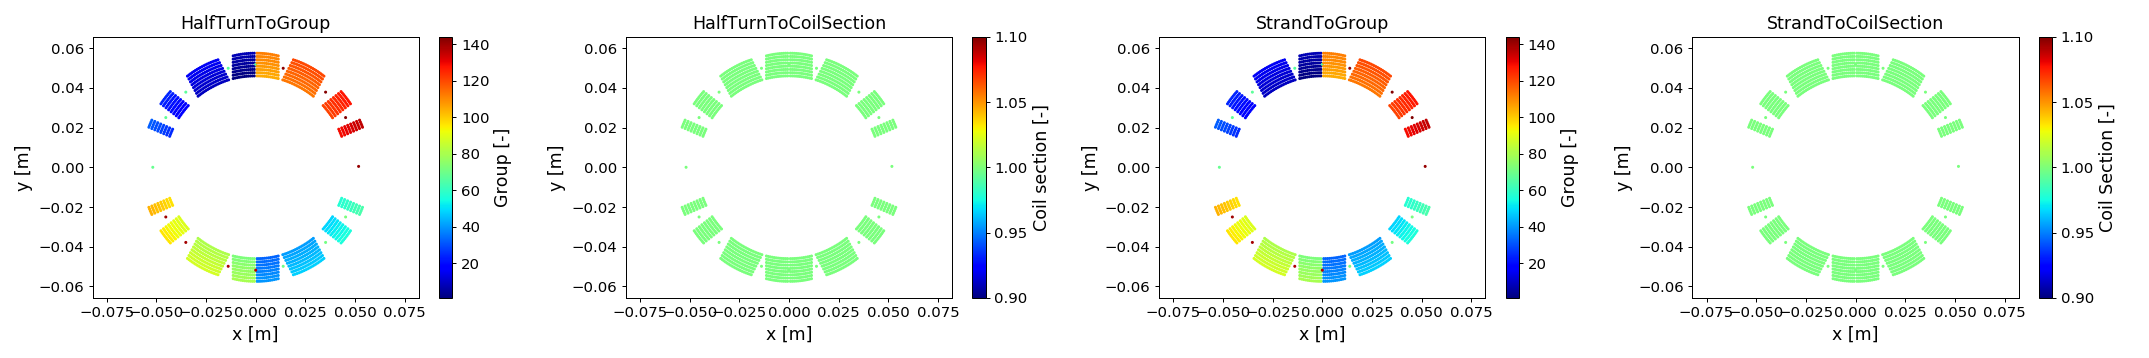

In [26]:
# Plot half-turn and strand properties
f = plt.figure(figsize=(24,4))
plt.subplot(1, 4, 1 )
plt.scatter(x_ave, y_ave, s=2, c=HalfTurnToGroup)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('HalfTurnToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x_ave, y_ave, s=2, c=HalfTurnToCoilSection)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('HalfTurnToCoilSection',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Coil section [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x, y, s=2, c=strandToGroup)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('StrandToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x, y, s=2, c=strandToCoilSection)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('StrandToCoilSection',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Coil Section [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()

# Differential inductance versus current (Iron-yoke effect) - IMPORT FROM ROXIE

<IPython.core.display.Javascript object>


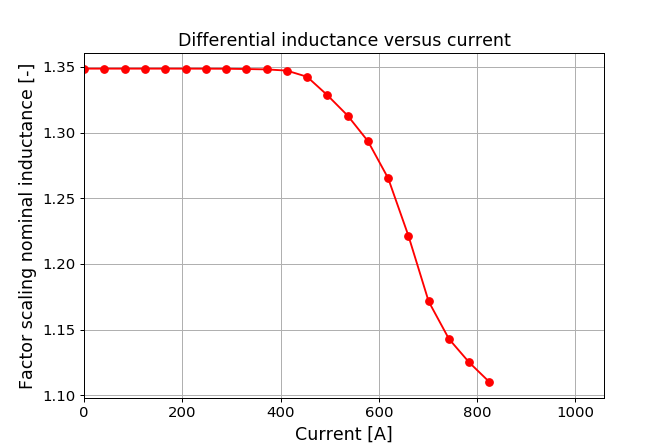

In [27]:
# Copy/paste the values after calculation using ROXIE or COMSOL or another software
fL_I = [0.55, 41.7725, 82.995, 124.2175, 165.44, 206.6625, 247.885, 289.1075, 330.33, 371.5525, 412.775, 453.9975, 495.22, 536.4425, 577.665, 618.8875, 660.11, 701.3325, 742.555, 783.7775, 825 ]
fL_L = [1.34865928668818, 1.34865928668818, 1.34865928668818, 1.34865928668818, 1.34865894285284, 1.34864901590971, 1.34861792746409, 1.34857535439705, 1.34837078278707, 1.34808735045727, 1.34715634072585, 1.34246069865974, 1.32845433672909, 1.3129222679783, 1.29349431816979, 1.26521394193709, 1.22140928534508, 1.17134172528175, 1.14283699127795, 1.12493239093362, 1.10998419366786 ]

# Plot
f = plt.figure(figsize=(7.5,5))
plt.plot(fL_I, fL_L, 'ro-')
plt.xlabel('Current [A]',**selectedFont)
plt.ylabel('Factor scaling nominal inductance [-]',**selectedFont)
plt.title('Differential inductance versus current',**selectedFont)
plt.xlim([0, I00*2])
plt.grid(True)
plt.rcParams.update({'font.size': 12})

# Time Vector Definition

<IPython.core.display.Javascript object>


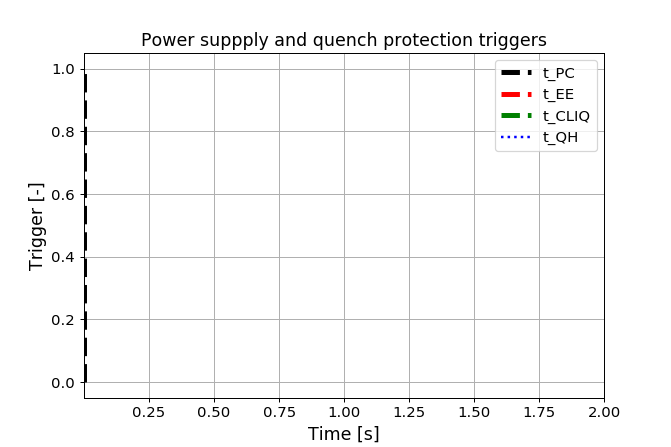

In [28]:
# Time Vector Definition. Parameters used to generate the time vector.
# Each triplet of numbers defines a time window: first element is the start time, second element is the time step in that window, third element is the end time. It must contain a number of elements multiple of 3. Any time point above t=1000 s will be ignored.
time_vector_params = [tStart, 5E-4, 0.75, 0.751, 0.001, 2]

# Plot
f = plt.figure(figsize=(7.5,5))
plt.plot([t_PC,t_PC], [0,1], 'k--', linewidth=4.0, label='t_PC')
plt.plot([tEE,tEE], [0,1], 'r--', linewidth=4.0, label='t_EE')
plt.plot([tCLIQ,tCLIQ], [0,1], 'g--', linewidth=4.0, label='t_CLIQ')
plt.plot([np.min(tQH),np.min(tQH)], [0,1], 'b:', linewidth=2.0, label='t_QH')
plt.xlabel('Time [s]',**selectedFont)
plt.ylabel('Trigger [-]',**selectedFont)
plt.xlim([1E-4,time_vector_params[-1]])
plt.title('Power suppply and quench protection triggers',**selectedFont)
plt.grid(True)
plt.rcParams.update({'font.size': 12})
plt.legend(loc='best')

# Options - Change something only if you know what you're doing

In [29]:
# Field-Map Files Options
Iref = Iref
flagIron = 1
flagSelfField = 1
headerLines = 1
columnsXY = [4, 5]
columnsBxBy = [6, 7]
flagPlotMTF = 0

# Input Generation Options
flag_calculateInductanceMatrix = 0
flag_useExternalInitialization = 0
flag_initializeVar = 0

# Simulation Run Options
flag_fastMode = 1
flag_controlCurrent = 0
flag_automaticRefinedTimeStepping = 1

# Simulation Physics Options
flag_IronSaturation = 1
flag_InvertCurrentsAndFields = 0
flag_ScaleDownSuperposedMagneticField = 1
flag_HeCooling = 2
fScaling_Pex = 1
fScaling_Pex_AlongHeight = fScaling_Pex_AlongHeight_Defined
fScaling_MR = 1
flag_scaleCoilResistance_StrandTwistPitch = 0
flag_separateInsulationHeatCapacity = 0
flag_ISCL = 0
fScaling_Mif = 1
fScaling_Mis = 1
flag_StopIFCCsAfterQuench = 0
flag_StopISCCsAfterQuench = 0
tau_increaseRif = 0.005
tau_increaseRis = 0.01
fScaling_RhoSS = 1.09
maxVoltagePC = 10
flag_symmetricGroundingEE = 0
flag_removeUc = 0
BtX_background = 0
BtY_background = 0

# Post-Processing Options
flag_showFigures = 0
flag_saveFigures = 0
flag_saveMatFile = 1
flag_saveTxtFiles = 0
flag_generateReport = 1
flag_hotSpotTemperatureInEachGroup = 0
MinMaxXY_MTF = [-200, 200, -100, 100]

# Define the values of all Plots variables - Change something only if you know what you're doing

In [30]:
# Define the values of all Plots variables
suffixPlot = []
typePlot = []
outputPlotSubfolderPlot = []
variableToPlotPlot = []
selectedStrandsPlot = []
selectedTimesPlot = []
labelColorBarPlot = []
minColorBarPlot = []
maxColorBarPlot = []
MinMaxXYPlot = []
flagSavePlot = []
flagColorPlot = []
flagInvisiblePlot = []

# Define the values of all Variables variables - Change something only if you know what you're doing

In [31]:
# Define the values of all Variables variables
variableToSaveTxt = ['time_vector', 'Ia', 'Ib', 'T_ht', 'dT_dt_ht', 'flagQ_ht', 'IifX', 'IifY', 'Iis', 'dIifXDt', 'dIifYDt', 'dIisDt', 'Uc', 'U_QH', 'T_s_QH', 'time_vector', 'R_CoilSections', 'U_inductive_dynamic_CoilSections', 'I_CoilSections']
typeVariableToSaveTxt = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1]
variableToInitialize = ['Ia', 'Ib', 'T_ht', 'dT_dt_ht', 'flagQ_ht', 'IifX', 'IifY', 'Iis', 'dIifXDt', 'dIifYDt', 'dIisDt', 'Uc', 'U_QH', 'T_s_QH']

# Add all Inputs, Options, Plots, and Variables variables to a list - DO NOT CHANGE

In [32]:
# Check if Inductance matrix to csv or xlsx
if M_InductanceBlock_m_Flag:
    M_InductanceBlock_m = np.array([0])

# Load default LEDET variable descriptions
paramLEDET = ParametersLEDET()

# Add all Inputs variables to a list - DO NOT CHANGE
paramLEDET.addVariablesInputs(
    T00, l_magnet, I00, M_m,
    fL_I, fL_L,
    GroupToCoilSection, polarities_inGroup, nT,
    nStrands_inGroup, l_mag_inGroup, ds_inGroup,
    f_SC_strand_inGroup, f_ro_eff_inGroup, Lp_f_inGroup,
    RRR_Cu_inGroup,
    SCtype_inGroup, STtype_inGroup, insulationType_inGroup,
    internalVoidsType_inGroup,
    externalVoidsType_inGroup,
    wBare_inGroup, hBare_inGroup, wIns_inGroup, hIns_inGroup,
    Lp_s_inGroup, R_c_inGroup,
    Tc0_NbTi_ht_inGroup, Bc2_NbTi_ht_inGroup,
    c1_Ic_NbTi_inGroup, c2_Ic_NbTi_inGroup,
    Tc0_Nb3Sn_inGroup, Bc2_Nb3Sn_inGroup, Jc_Nb3Sn0_inGroup,
    el_order_half_turns,
    alphasDEG, rotation_block, mirror_block, mirrorY_block,
    iContactAlongWidth_From, iContactAlongWidth_To,
    iContactAlongHeight_From,
    iContactAlongHeight_To,
    iStartQuench, tStartQuench, lengthHotSpot_iStartQuench,
    vQ_iStartQuench,
    R_circuit, R_crowbar, Ud_crowbar, t_PC, t_PC_LUT, I_PC_LUT,
    tEE, R_EE_triggered,
    tCLIQ, directionCurrentCLIQ, nCLIQ, U0, C, Rcapa,
    tQH, U0_QH, C_QH, R_warm_QH, w_QH, h_QH, s_ins_QH, type_ins_QH,
    s_ins_QH_He, type_ins_QH_He, l_QH, f_QH,
    iQH_toHalfTurn_From, iQH_toHalfTurn_To,
    tQuench, initialQuenchTemp,
    HalfTurnToInductanceBlock, M_InductanceBlock_m
)

# Add all Options variables to a list - DO NOT CHANGE
paramLEDET.addVariablesOptions(
    time_vector_params,
    Iref, flagIron, flagSelfField, headerLines, columnsXY, columnsBxBy, flagPlotMTF,
    flag_calculateInductanceMatrix, flag_useExternalInitialization, flag_initializeVar,
    flag_fastMode, flag_controlCurrent, flag_automaticRefinedTimeStepping, flag_IronSaturation,
    flag_InvertCurrentsAndFields, flag_ScaleDownSuperposedMagneticField, flag_HeCooling, fScaling_Pex, fScaling_Pex_AlongHeight,
    fScaling_MR, flag_scaleCoilResistance_StrandTwistPitch, flag_separateInsulationHeatCapacity,
    flag_ISCL, fScaling_Mif, fScaling_Mis, flag_StopIFCCsAfterQuench, flag_StopISCCsAfterQuench, tau_increaseRif, tau_increaseRis,
    fScaling_RhoSS, maxVoltagePC, flag_symmetricGroundingEE, flag_removeUc, BtX_background, BtY_background,
    flag_showFigures, flag_saveFigures, flag_saveMatFile, flag_saveTxtFiles, flag_generateReport,
    flag_hotSpotTemperatureInEachGroup, MinMaxXY_MTF
)

# Define the values of all Plots variables - DO NOT CHANGE
paramLEDET.addVariablesPlots(
    suffixPlot, typePlot, outputPlotSubfolderPlot, variableToPlotPlot, selectedStrandsPlot, selectedTimesPlot,
    labelColorBarPlot, minColorBarPlot, maxColorBarPlot, MinMaxXYPlot, flagSavePlot, flagColorPlot, flagInvisiblePlot
)

# Define the values of all Variables variables - DO NOT CHANGE
paramLEDET.addVariablesVariables(
    variableToSaveTxt, typeVariableToSaveTxt, variableToInitialize
)

# Visualize the defined variables

In [33]:
if verbose:
    # Visualize variable descriptions, names, and values
    print('### "Inputs" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupInputs, paramLEDET.variablesInputs)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Options" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupOptions, paramLEDET.variablesOptions)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Plots" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupPlots, paramLEDET.variablesPlots)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Variables" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupVariables, paramLEDET.variablesVariables)

# Write the LEDET input file

In [34]:
nameFileLEDET = nameMagnet + '_CopperWedges_0' + '.xlsx'
paramLEDET.writeFileLEDET(nameFileLEDET)

Preliminary consistency check was successful! -  MCBXV_CopperWedges_0.xlsx
